# Appendix: attempts at classifying .wav data directly

This part wasn't used to get results because it didn't yield satisfactory results. But a lot of time was spent building this dataloading pipeline.

In [0]:
from google.colab import drive 
drive.mount('/mntDrive') 

In [0]:
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchaudio
import glob
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn
import cv2
from __future__ import print_function, division
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import copy

### visualization

/


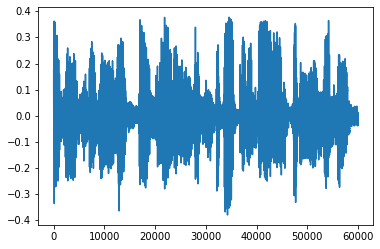

In [0]:
#hardcoded path to .wav fil in the drive
%cd ..
filename ='/mntDrive/My Drive/Vox_celeb/VoxCeleb_moi/data/dataset/audio/1_00001.wav'


#visualization of audio sample in the time domain

waveform, sample_rate = torchaudio.load(filename)
waveform=waveform[:,:60000]

plt.figure()
plt.plot(waveform.t().numpy()[:60000,:])

Shape of spectrogram: torch.Size([1, 128, 301])


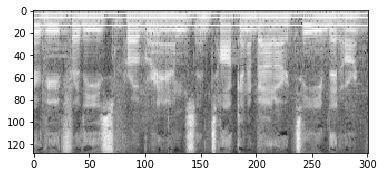

In [0]:
#visualisation of the audiosample on the time frequency domain thanks to meltransform

specgram = torchaudio.transforms.MelSpectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy(), cmap='gray')

## Data loaders

In [0]:
# hardcoded path to the csv document linking id to male or female label
labs = pd.read_csv('/mntDrive/My Drive/Vox_celeb/label.csv')


# custom class to import dataset
class AudioDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, labels , cat, transform):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            L (list of string): path to all .wav files
            labels (pandas df): df with ids and corresponding labels
            cat string 'train', 'test' or 'val': type of dataset
        """
        self.root_dir = root_dir
        self.cat = cat
        self.transform = transform
        self.labels=labels

    def __len__(self):
        return len(glob.glob(str('/mntDrive/My Drive/Vox_celeb/VoxCeleb_theo/'+self.cat+'/*/*.wav')))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        L = glob.glob(str('/mntDrive/My Drive/Vox_celeb/VoxCeleb_theo/'+self.cat+'/*/*.wav'))

        aud_name = os.path.join(L[idx])
        waveform, sample_rate = torchaudio.load(aud_name)
        waveform=waveform[:,:60000]

        sample = {'audio': waveform, 'label': self.labels[self.labels.id == int(L[idx].split('/')[-2][2:])].label.values[0]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [0]:
#custom class to transform an audiodataset containing time series into dataset conatining spectrogramm
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])


class MelSpec(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, sample_rate):
        self.sample_rate = sample_rate

    def __call__(self, sample):
        audio, label = sample['audio'], sample['label']
        audio = torchaudio.transforms.MelSpectrogram(sample_rate=16000)(audio)
        img = audio.log2()[0,:,:].detach().numpy()
        img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img,(224,224),cv2.INTER_CUBIC)
        tens = transforms.ToTensor()(img)
        tens = normalize(tens)
        return {'audio': tens, 'label': label}
        #return(audio)

In [0]:
#importing our 3 datasets

image_datasets = {x: AudioDataset('/mntDrive/My Drive/Vox_celeb/VoxCeleb_moi/data/dataset/audio/',labs,x,transform=transforms.Compose([
                                               MelSpec(1600)#,
                                               #transforms.ToPILImage(),
                                               #transforms.Resize(224),
                                               #transforms.ToTensor(),
                                               #normalize
                                           ]))
                  for x in ['train', 'val']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=256,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['test', 'val']}

## Transfer learning

In [0]:
# during the training phase, we are keeping in memory the epoch that has the best validation accuracy 

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            print(phase)
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            j=0
            # Iterate over data.
            for data in dataloaders[phase]:
                j+=1
                print(j)
                inputs = data['audio'].to(device)
                labels = data['label'].to(device)

                # zero the parameter gradients
                print(labels)
                optimizer.zero_grad()

                # forward
                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        print("backward")
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                print(preds)
                print("number of corrects")
                print(running_corrects)
                print("total number")
                print(inputs.size(0))
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                PATH = 'mntDrive/My Drive/Vox_celeb/VoxCeleb_theo/first.pth'
                torch.save(model.state_dict(), PATH)      

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# implementing transfer learning

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# adding one more linear layer
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# implementing a learning rate decay
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
# training the model. Unfortunately, Google colab session crashed time each before having obtained satisfying results. 
# Should have been implemented on Google Cloud services.

model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
test
1
tensor([0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
backward
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        